# Raw angles models

## Imports

In [ ]:
import time
from utils import *
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from sklearn.metrics import mean_absolute_error, r2_score

Here, I tried to compute a custom loss based on the Euclidian distance. Noting $\theta$ and $\phi$ respectively the actual and predicted angles, the expression of the Euclidian distance will be:

$d²_E(\theta, \phi)=(\cos\theta-\cos\phi)²+(\sin\theta-\sin\phi)²$

$d²_E(\theta, \phi)=\cos²\theta-2\cos\theta \cos\phi + \cos²\phi+\sin²\theta-2\sin\theta\sin\phi + \sin²\phi$

$d²_E(\theta, \phi)=2-2\cos(\theta-\phi)$

By using this function, we just need to provide the angles values as the model input without needing their cosines and sines. Here follows the whole process:

### I - 2D with 2 joints

##### Data processing

In [24]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(2))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.0,0.034,0.003,0.21,0.007,1.0,0.018
1,0.048,0.004,0.999,1.0,0.048,0.004,0.21,0.010,1.0,0.026


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [25]:
X_2R_raw = df_2R[['j0', ' j1']].values
X_2R_raw = pd.DataFrame(X_2R_raw, columns=['j0', 'j1'])
display(X_2R_raw.head(2))

y_2R_pos = df_2R[[' ee_x', ' ee_y']].values
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(2))

,j0,j1
0,0.034,0.003
1,0.048,0.004


,ee_x,ee_y,ee_qw,ee_qz
0,0.21,0.007,1.0,0.018
1,0.21,0.010,1.0,0.026


In [26]:
percentage_2R = 0.1
X_2R_train, X_2R_test, y_2R_train, y_2R_test = train_test_split(X_2R_raw, y_2R_pos, test_size=0.2, random_state=2184503)

subset_size_train = int(len(X_2R_train)*percentage_2R)
subset_size_test = int(len(X_2R_test)*percentage_2R)
X_2R_train = X_2R_train[:subset_size_train]
y_2R_train = y_2R_train[:subset_size_train]
X_2R_test = X_2R_test[:subset_size_test]
y_2R_test = y_2R_test[:subset_size_test]

print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(8000, 2) (8000, 2)
(2000, 2) (2000, 2)


##### Model

In [27]:
model_2R = Sequential()
model_2R.add(Input((X_2R_train.shape[1],)))
model_2R.add(Dense(16, activation="relu"))
model_2R.add(Dense(16, activation="relu"))
model_2R.add(Dense(y_2R_train.shape[1], activation="linear"))

model_2R.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354 (1.38 KB)

 Trainable params: 354 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_2R = 30

model_2R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

start = time.time()
history_2R = model_2R.fit(X_2R_train, y_2R_train,
                    epochs=epochs_2R,
                    validation_data=(X_2R_test, y_2R_test),
                    verbose=1)
training_time = time.time() - start


y_2R_train_pred = model_2R.predict(X_2R_train)
y_2R_test_pred = model_2R.predict(X_2R_test)

mae_2R_train = mean_absolute_error(y_2R_train, y_2R_train_pred)
mae_2R_test = mean_absolute_error(y_2R_test, y_2R_test_pred)

r2_2R_test = r2_score(y_2R_test, y_2R_test_pred)
r2_2R_train = r2_score(y_2R_train, y_2R_train_pred)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1486 - val_loss: 0.0034
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 8.8890e-04
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6690e-04 - val_loss: 7.3093e-04
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1160e-04 - val_loss: 6.0154e-04
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9469e-04 - val_loss: 5.7412e-04
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4182e-04 - val_loss: 4.9718e-04
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0386e-04 - val_loss: 4.4888e-04
Ep

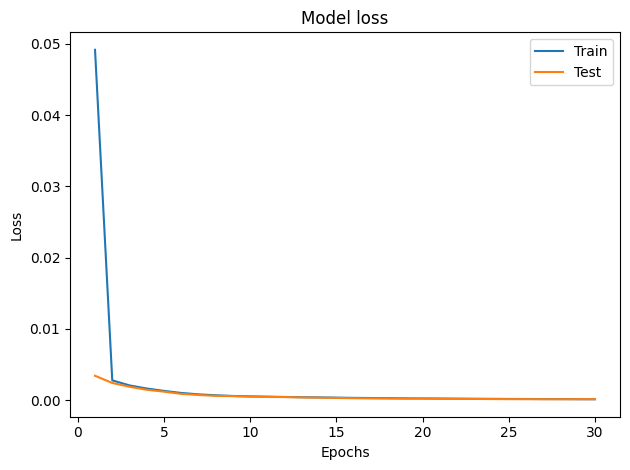

In [ ]:
displayLearningCurve(history=history_2R, 
                    epochs=epochs_2R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_2R.history['loss'][-1]}\nTest: {history_2R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_2R_train}\nTest: {mae_2R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_2R_train}\nTest: {r2_2R_test}")

### II - 2D with 3 joints

In [30]:
filepath_3R = r'data/3R_2184503_100.csv'
df_3R = pd.read_csv(filepath_3R, sep=";", header=0).copy()

display(df_3R.head(3))
df_3R.info()

,j0,j1,j2,cos(j0),cos(j1),cos(j2),sin(j0),sin(j1),sin(j2),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,-0.002,0.999,1.0,1.0,0.034,0.003,-0.002,0.310,0.011,1.000,0.017
1,0.047,0.004,-0.003,0.999,1.0,1.0,0.047,0.004,-0.003,0.310,0.015,1.000,0.024
2,0.105,0.001,-0.008,0.994,1.0,1.0,0.105,0.001,-0.008,0.308,0.032,0.999,0.049


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    cos(j0)  100000 non-null  float64
 4    cos(j1)  100000 non-null  float64
 5    cos(j2)  100000 non-null  float64
 6    sin(j0)  100000 non-null  float64
 7    sin(j1)  100000 non-null  float64
 8    sin(j2)  100000 non-null  float64
 9    ee_x     100000 non-null  float64
 10   ee_y     100000 non-null  float64
 11   ee_qw    100000 non-null  float64
 12   ee_qz    100000 non-null  float64
dtypes: float64(13)
memory usage: 9.9 MB


In [31]:
X_3R_raw = df_3R[['j0', ' j1', ' j2']].values
X_3R_raw = pd.DataFrame(X_3R_raw, columns=['j0', 'j1', 'j2'])
display(X_3R_raw.head(2))

y_3R_pos = df_3R[[' ee_x', ' ee_y']].values
y_3R_ori = df_3R[[' ee_qw', ' ee_qz']].values
y_3R = pd.concat([pd.DataFrame(y_3R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_3R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_3R.head(2))

,j0,j1,j2
0,0.034,0.003,-0.002
1,0.047,0.004,-0.003


,ee_x,ee_y,ee_qw,ee_qz
0,0.31,0.011,1.0,0.017
1,0.31,0.015,1.0,0.024


In [32]:
X_3R_train, X_3R_test, y_3R_train, y_3R_test = train_test_split(X_3R_raw, y_3R_pos, test_size=0.2, random_state=2184503)
print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(80000, 3) (80000, 2)
(20000, 2) (20000, 2)


In [33]:
percentage_3R = 0.1

subset_size_train = int(len(X_3R_train)*percentage_3R)
subset_size_test = int(len(X_3R_test)*percentage_3R)

X_3R_train = X_3R_train[:subset_size_train]
y_3R_train = y_3R_train[:subset_size_train]
X_3R_test = X_3R_test[:subset_size_test]
y_3R_test = y_3R_test[:subset_size_test]

print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(8000, 3) (8000, 2)
(2000, 2) (2000, 2)


In [34]:
model_3R = Sequential()
model_3R.add(Input((X_3R_train.shape[1],)))
model_3R.add(Dense(16, activation="relu"))
model_3R.add(Dense(16, activation="relu"))
model_3R.add(Dense(y_3R_train.shape[1], activation="linear"))
model_3R.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370 (1.45 KB)

 Trainable params: 370 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

epochs_3R = 20
start = time.time()
history_3R = model_3R.fit(X_3R_train, y_3R_train,
                    epochs=epochs_3R,
                    validation_data=(X_3R_test, y_3R_test),
                    verbose=1)
training_time = time.time() - start


y_3R_train_pred = model_3R.predict(X_3R_train)
y_3R_test_pred = model_3R.predict(X_3R_test)

mae_3R_train = mean_absolute_error(y_3R_train, y_3R_train_pred)
mae_3R_test = mean_absolute_error(y_3R_test, y_3R_test_pred)

r2_3R_test = r2_score(y_3R_test, y_3R_test_pred)
r2_3R_train = r2_score(y_3R_train, y_3R_train_pred)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0697 - val_loss: 0.0107
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 9.0404e-04
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0479e-04 - val_loss: 9.3310e-04
Epoch 12/30
250/250 ━━━━━━━━━━━━━━━━

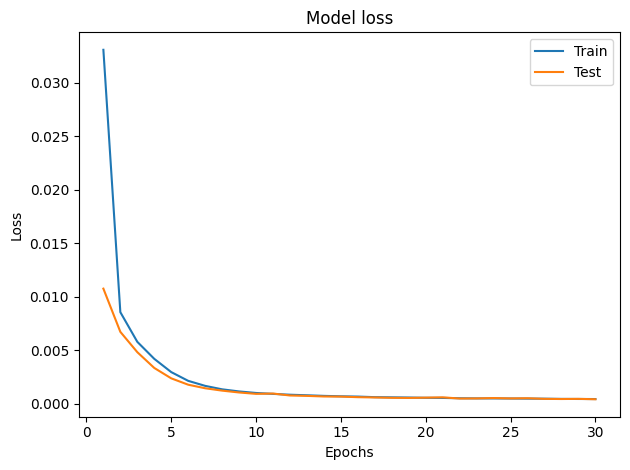

In [ ]:
displayLearningCurve(history=history_3R, 
                    epochs=epochs_3R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_3R.history['loss'][-1]}\nTest: {history_3R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_3R_train}\nTest: {mae_3R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_3R_train}\nTest: {r2_3R_test}\n")

### III - 3D with 5 joints

In [37]:
filepath_5R = r'data/5R_2184503_100.csv'
df_5R = pd.read_csv(filepath_5R, sep=";", header=0).copy()

display(df_5R.head(2))
df_5R.info()

,j0,j1,j2,j3,j4,cos(j0),cos(j1),cos(j2),cos(j3),cos(j4),...,sin(j2),sin(j3),sin(j4),ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000,0.000,0.000,0.59,1.0,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005,1.0,1.0,1.0,1.0,1.0,...,-0.001,0.031,-0.005,0.007,0.001,0.59,1.0,-0.003,0.016,0.007


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    j3       100000 non-null  float64
 4    j4       100000 non-null  float64
 5    cos(j0)  100000 non-null  float64
 6    cos(j1)  100000 non-null  float64
 7    cos(j2)  100000 non-null  float64
 8    cos(j3)  100000 non-null  float64
 9    cos(j4)  100000 non-null  float64
 10   sin(j0)  100000 non-null  float64
 11   sin(j1)  100000 non-null  float64
 12   sin(j2)  100000 non-null  float64
 13   sin(j3)  100000 non-null  float64
 14   sin(j4)  100000 non-null  float64
 15   ee_x     100000 non-null  float64
 16   ee_y     100000 non-null  float64
 17   ee_z     100000 non-null  float64
 18   ee_qw    100000 non-null  float64
 19   ee_qx    100000 non-null  float64
 20   ee_q

In [38]:
X_5R_raw = df_5R[['j0', ' j1', ' j2', ' j3', ' j4']].values
X_5R_raw = pd.DataFrame(X_5R_raw, columns=['j0', 'j1', 'j2', 'j3', 'j4'])
display(X_5R_raw.head(2))

,j0,j1,j2,j3,j4
0,0.000,0.000,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005


In [39]:
y_5R_pos = df_5R[[' ee_x', ' ee_y', ' ee_z']].values
y_5R_ori = df_5R[[' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']].values
y_5R = pd.concat([pd.DataFrame(y_5R_pos, columns=['ee_x', 'ee_y', "ee_z"]), 
                         pd.DataFrame(y_5R_ori, columns=['ee_qw', 'ee_qx', 'ee_qy', 'ee_qz'])], axis=1)

display(y_5R.head(2))

,ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.59,1.0,0.000,0.000,0.000
1,0.007,0.001,0.59,1.0,-0.003,0.016,0.007


In [40]:
X_5R_train, X_5R_test, y_5R_train, y_5R_test = train_test_split(X_5R_raw, y_5R_pos, test_size=0.2, random_state=2184503)
print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(80000, 5) (80000, 3)
(20000, 3) (20000, 3)


In [41]:
percentage_5R = 0.8

subset_size_train = int(len(X_5R_train)*percentage_5R)
subset_size_test = int(len(X_5R_test)*percentage_5R)

X_5R_train = X_5R_train[:subset_size_train]
y_5R_train = y_5R_train[:subset_size_train]
X_5R_test = X_5R_test[:subset_size_test]
y_5R_test = y_5R_test[:subset_size_test]

print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(64000, 5) (64000, 3)
(16000, 3) (16000, 3)


In [42]:
model_5R = Sequential()
model_5R.add(Input((X_5R_train.shape[1],)))
model_5R.add(Dense(16, activation="relu"))
model_5R.add(Dense(16, activation="relu"))
model_5R.add(Dense(y_5R_train.shape[1], activation="linear"))
model_5R.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419 (1.64 KB)

 Trainable params: 419 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_5R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

epochs_5R = 20
start = time.time()
history_5R = model_5R.fit(X_5R_train, y_5R_train,
                    epochs=epochs_5R,
                    validation_data=(X_5R_test, y_5R_test),
                    verbose=1)
training_time = time.time() - start


y_5R_train_pred = model_5R.predict(X_5R_train)
y_5R_test_pred = model_5R.predict(X_5R_test)

mae_5R_train = mean_absolute_error(y_5R_train, y_5R_train_pred)
mae_5R_test = mean_absolute_error(y_5R_test, y_5R_test_pred)

r2_5R_test = r2_score(y_5R_test, y_5R_test_pred)
r2_5R_train = r2_score(y_5R_train, y_5R_train_pred)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0385 - val_loss: 0.0047
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 877us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - loss: 9.6061e-04 - val_loss: 9.2947e-04
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - loss: 9.2050e-04 - val_loss: 8.7772e

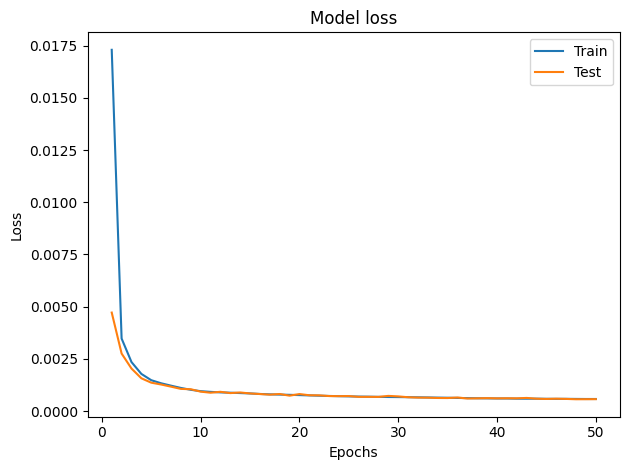

In [ ]:
displayLearningCurve(history=history_5R, 
                    epochs=epochs_5R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_5R.history['loss'][-1]}\nTest: {history_5R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_5R_train}\nTest: {mae_5R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_5R_train}\nTest: {r2_5R_test}")

##### Saving models

In [ ]:
# model_2R.save(filepath=f'models/NN1_2R_p{int(percentage_2R*100)}_e{epochs_2R}_raw.keras')
# model_3R.save(filepath=f'models/NN1_3R_p{int(percentage_3R*100)}_e{epochs_3R}_raw.keras')
# model_5R.save(filepath=f'models/NN1_5R_p{int(percentage_5R*100)}_e{epochs_5R}_raw.keras')